In [1]:
from transformers import AutoProcessor, MusicgenForConditionalGeneration
import torch, os, glob, json, math
from torch import nn
import numpy as np
import onnxruntime as ort
import inspect

export_onnx = True
test_onnx = True
conv_p = False
export_torch_script = False
test_torch_script = False
do_model_sample = False

folder = './musicgen-stereo-small'
os.makedirs(folder, exist_ok=True)

cfg = 5
temperature = 0.7
top_k = 500
top_p = 0.0
max_len = 256
optset_version = 14

/home/bas/anaconda3/envs/musiclm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = AutoProcessor.from_pretrained("facebook/musicgen-stereo-small")

In [3]:
if do_model_sample or test_torch_script or export_onnx:
    model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-stereo-small")
    model.eval()

/home/bas/anaconda3/envs/musiclm/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/home/bas/anaconda3/envs/musiclm/lib/python3.10/site-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


Test run throughputs

In [4]:
inputs = processor(
    text=["80s pop track with bassy drums and synth asd asd asd"],
    padding=True,
    return_tensors="pt",
)
if do_model_sample:
    res = model.generate(**inputs, do_sample=True, guidance_scale=cfg, max_new_tokens=max_len, temperature=temperature, top_k=top_k, top_p=top_p)
# res, output_ids = model.generate(**inputs, do_sample=False, guidance_scale=5, max_new_tokens=256)

In [5]:
import matplotlib.pyplot as plt

def plot_stereo_audio_from_array(audio_data):
    """
    Plots the left and right channels of a stereo audio signal.

    Parameters:
    audio_data (numpy array): A 2D NumPy array with shape (channels, samples).
    sample_rate (int): The sample rate of the audio signal.
    """
    # Check if the audio is stereo (2 channels)
    if audio_data.shape[0] == 2:
        # Extract the left and right channels
        left_channel = audio_data[0, :]
        right_channel = audio_data[1, :]

        # Create time axis in seconds
        time = [i / 32000 for i in range(audio_data.shape[1])]

        # Plot the left and right channels
        plt.figure(figsize=(12, 6))

        # Plot left channel
        plt.subplot(2, 1, 1)
        plt.plot(time, left_channel, color='blue')
        plt.title('Left Channel')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')

        # Plot right channel
        plt.subplot(2, 1, 2)
        plt.plot(time, right_channel, color='green')
        plt.title('Right Channel')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')

        # Show the plot
        plt.tight_layout()
        plt.show()
    else:
        print("The audio data is not stereo (it does not have 2 channels).")

In [6]:
if do_model_sample:
    plot_stereo_audio_from_array(res[0].detach().numpy())

In [7]:
if do_model_sample:
    from IPython.display import Audio

    sampling_rate = model.config.audio_encoder.sampling_rate
    Audio(res[0].detach().numpy(), rate=sampling_rate)

In [8]:
# import scipy

# sampling_rate = model.config.audio_encoder.sampling_rate
# scipy.io.wavfile.write("musicgen_out.wav", rate=sampling_rate, data=res[0].detach().numpy().T)

### Exporting the model
TODO:
- [x] Configuration lists exported
- [x] Text encoder exported
- [x] Projection layer exported
- [x] Decoder layer exported
- [ ] Sampling function exported
- [x] Output decoder exported
- [ ] Look at making layers efficient
- [ ] Full model throughput test
- [ ] Research way to export the sample input version

Flow:                                                           This will be in a forloop
tokenized inputs and mask -> Text Encoder -> PreLoop -> [Sample] -> Audio Encoder -> Wav

Export configs

In [9]:
if test_torch_script or export_onnx:
    processor.tokenizer.save_pretrained(f'{folder}')
    processor.save_pretrained(f'{folder}')
    model.config.to_json_file(f'{folder}/config.json')
    model.generation_config.to_json_file(f'{folder}/generation_config.json')

#### Export text encoder

In [10]:
class TextEncoderWrapper(nn.Module):
    def __init__(self, text_encoder):
        super().__init__()
        self.text_encoder = text_encoder

    def forward(self, input_ids, attention_mask, cfg=None):
        last_hidden_state = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        if cfg is not None:
            cfg_tensor = cfg.unsqueeze(0)  # Convert to tensor for ONNX
            condition = (cfg_tensor > 1).float()  # Create a condition tensor
            if condition: # This enforces the addition of cfg as a variable
                last_hidden_state = torch.concatenate([condition * last_hidden_state, torch.zeros_like(last_hidden_state)], dim=0)
                res_attention_mask = torch.concatenate([condition * attention_mask, torch.zeros_like(attention_mask)], dim=0)
        else:
            res_attention_mask = attention_mask

        return last_hidden_state, res_attention_mask

In [11]:
if export_torch_script:
    text_encoder_wrapper = TextEncoderWrapper(model.text_encoder)
    text_encoder_wrapper.eval()
    scripted_model = torch.jit.script(text_encoder_wrapper)  # or torch.jit.trace for simple models
    scripted_model.save(f"{folder}/text_encoder_wrapper.pt")

In [12]:
if export_onnx:
    text_encoder_wrapper = TextEncoderWrapper(model.text_encoder)
    text_encoder_wrapper.eval()

    # Define the dynamic axes for variable-length input shapes
    dynamic_axes = {
        'input_ids': {0: 'batch_size', 1: 'sequence_length'},  # Allow variable batch size and sequence length
        'attention_mask': {0: 'batch_size', 1: 'sequence_length'},  # Allow variable batch size and sequence length
        'encoded': {0: 'batch_size', 1: 'sequence_length'}  # Output will also have variable batch size and sequence length
    }

    # Example input shapes (with batch size = 2, sequence length = 10)
    dummy_input_ids = torch.randint(0, 100, (1, 18), dtype=torch.int64)
    dummy_attention_mask = torch.randint(0, 100, (1, 18), dtype=torch.int64)
    dummy_cfg = torch.tensor(3, dtype=torch.int64)

    # Export the model to ONNX format
    torch.onnx.export(
        text_encoder_wrapper,
        (dummy_input_ids, dummy_attention_mask, dummy_cfg),
        f"{folder}/text_encoder.onnx",
        input_names=['input_ids', 'attention_mask', 'cfg'],
        output_names=['last_hidden_state', 'res_attention_mask'],
        dynamic_axes=dynamic_axes,
        opset_version=optset_version
    )

/home/bas/anaconda3/envs/musiclm/lib/python3.10/site-packages/torch/onnx/utils.py:2078: UserWarning: Provided key encoded for dynamic axes is not a valid input/output name
  warnings.warn(
/tmp/ipykernel_1055666/2558516118.py:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if condition: # This enforces the addition of cfg as a variable


#### Export the audio_encoder

Make a PT wrapper for the decoding portion of the model

In [13]:
class DecodeAudioWrapper(nn.Module):
    def __init__(self, audio_encoder):
        super().__init__()
        self.audio_encoder = audio_encoder

    def apply_delay_pattern_mask(self, input_ids, decoder_pad_token_mask):
        seq_len = input_ids.shape[-1]
        decoder_pad_token_mask = decoder_pad_token_mask[..., :seq_len]
        input_ids = torch.where(decoder_pad_token_mask == -1, input_ids, decoder_pad_token_mask)
        return input_ids

    def forward(self, output_ids: torch.Tensor, decoder_delay_pattern_mask: torch.Tensor, pad_token_id: int):
        '''Taken from last section of the model'''

        batch_size = 1 # We will only allow sampling of single samples for now, otherwise it might be too slow

        # apply the pattern mask to the final ids
        output_ids = self.apply_delay_pattern_mask(output_ids, decoder_delay_pattern_mask)

        # revert the pattern delay mask by filtering the pad token id
        output_ids = output_ids[output_ids != pad_token_id].reshape(
            batch_size, 8, -1
        )

        # append the frame dimension back to the audio codes
        output_ids = output_ids[None, ...]

        audio_scales = [None] * batch_size

        codec_outputs_left = self.audio_encoder.decode(output_ids[:, :, ::2, :], audio_scales=audio_scales)
        output_values_left = codec_outputs_left.audio_values

        codec_outputs_right = self.audio_encoder.decode(output_ids[:, :, 1::2, :], audio_scales=audio_scales)
        output_values_right = codec_outputs_right.audio_values

        output_values = torch.cat([output_values_left, output_values_right], dim=1)

        return output_values

In [14]:
if export_torch_script:
    audio_decoder_wrapper = DecodeAudioWrapper(model.audio_encoder)
    audio_decoder_wrapper.eval()
    scripted_model = torch.jit.script(audio_decoder_wrapper)  # or torch.jit.trace for simple models
    scripted_model.save(f"{folder}/audio_decoder_wrapper.pt")

In [15]:
if export_onnx:
    audio_decoder_wrapper = DecodeAudioWrapper(model.audio_encoder)
    audio_decoder_wrapper.eval()

    # Define the dynamic axes for variable-length input shapes
    dynamic_axes = {
        'output_ids': {1: 'sequence_length'}, # Allow variable batch size and sequence length
        'decoder_delay_pattern_mask': {1: 'sequence_length'}  # Output will also have variable batch size and sequence length
    }

    # Example input shapes (with batch size = 2, sequence length = 10)
    dummy_output_ids = torch.randint(0, 100, (8, 257), dtype=torch.int64)
    dummy_decoder_delay_pattern_mask = torch.randint(0, 100, (8, 257), dtype=torch.int64)
    dummy_pad_token_id = torch.tensor([2048], dtype=torch.int64)

    # Export the model to ONNX format
    torch.onnx.export(
        audio_decoder_wrapper,
        (dummy_output_ids, dummy_decoder_delay_pattern_mask, dummy_pad_token_id),
        f"{folder}/audio_token_decoder.onnx", 
        input_names=[
            'output_ids',
            'decoder_delay_pattern_mask',
            'pad_token_id'
        ],
        output_names=['output_values'],
        dynamic_axes=dynamic_axes,
        opset_version=optset_version
    )

/home/bas/anaconda3/envs/musiclm/lib/python3.10/site-packages/transformers/models/encodec/modeling_encodec.py:736: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  if len(audio_codes) != 1:
/home/bas/anaconda3/envs/musiclm/lib/python3.10/site-packages/transformers/models/encodec/modeling_encodec.py:433: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  quantized_out = torch.tensor(0.0, device=codes.device)
/home/bas/anaconda3/envs/musiclm/lib/python3.10/site-packages/transformers/models/encodec/modeling_encodec.py:434: TracerWarning: Iterating over a tensor might c

#### Export the pre_loop

In [16]:
class PreLoop(nn.Module):
    def __init__(self, num_codebooks=8, audio_channels=2):
        super().__init__()
        self.num_codebooks = num_codebooks
        self.audio_channels = audio_channels

    @staticmethod
    def build_delay_pattern_mask(self, input_ids, pad_token_id, max_length):
        input_ids = input_ids.reshape(-1, self.num_codebooks, input_ids.shape[-1])
        bsz, num_codebooks, seq_len = input_ids.shape

        max_length = max_length.unsqueeze(0)  # Convert to tensor for ONNX
        condition = (max_length > 0).long()  # Create a condition tensor

        input_ids_shifted = condition * (
            torch.ones((bsz, num_codebooks, max_length.item()), dtype=torch.long, device=input_ids.device) * -1
        )

        max_length = max_length.item()

        channel_codebooks = num_codebooks // 2 if self.audio_channels == 2 else num_codebooks
        # we only apply the mask if we have a large enough seq len - otherwise we return as is
        if max_length < 2 * channel_codebooks - 1:
            return input_ids.reshape(bsz * num_codebooks, -1), input_ids_shifted.reshape(bsz * num_codebooks, -1)

        # fill the shifted ids with the prompt entries, offset by the codebook idx
        for codebook in range(channel_codebooks):
            if self.audio_channels == 1:
                # mono channel - loop over the codebooks one-by-one
                input_ids_shifted[:, codebook, codebook : seq_len + codebook] = input_ids[:, codebook]
            else:
                # left/right channels are interleaved in the generated codebooks, so handle one then the other
                input_ids_shifted[:, 2 * codebook, codebook : seq_len + codebook] = input_ids[:, 2 * codebook]
                input_ids_shifted[:, 2 * codebook + 1, codebook : seq_len + codebook] = input_ids[:, 2 * codebook + 1]
        # construct a pattern mask that indicates the positions of padding tokens for each codebook
        # first fill the upper triangular part (the EOS padding)
        delay_pattern = torch.triu(
            torch.ones((channel_codebooks, max_length), dtype=torch.bool), diagonal=max_length - channel_codebooks + 1
        ).to(torch.int64)
        # then fill the lower triangular part (the BOS padding)
        delay_pattern = delay_pattern + torch.tril(torch.ones((channel_codebooks, max_length), dtype=torch.int64))

        if self.audio_channels == 2:
            # for left/right channel we need to duplicate every row of the pattern mask in an interleaved fashion
            delay_pattern = delay_pattern.repeat_interleave(2, dim=0)

        delay_pattern = delay_pattern.to(torch.bool)

        mask = ~delay_pattern.to(input_ids.device)
        input_ids = mask * input_ids_shifted + ~mask * pad_token_id

        # find the first position to start generating - this is the first place we have the -1 token
        # and will always be in the first codebook (since it has no codebook offset)
        first_codebook_ids = input_ids[:, 0, :]
        start_ids = (first_codebook_ids == -1).nonzero()[:, 1]
        if len(start_ids) > 0:
            first_start_id = min(start_ids)
        else:
            # we have no tokens that need to be filled - return entire matrix of input ids
            first_start_id = seq_len

        # (bsz * num_codebooks, seq_len) -> (bsz, num_codebooks, seq_len)
        pattern_mask = input_ids.reshape(bsz * num_codebooks, -1)
        input_ids = input_ids[..., :first_start_id].reshape(bsz * num_codebooks, -1)
        
        return input_ids, pattern_mask 

    def forward(self, batch_size: torch.Tensor, decoder_input_ids=None, decoder_attention_mask=None, max_length=torch.tensor(256, dtype=torch.int64)):
        # TODO: Impl for audio input (uses decoder_input_ids and decoder_attention_mask)
        # Equal to #5 _prepare_decoder_input_ids_for_generation
        decoder_start_token_id = 2048
        pad_token_id = 2048
        decoder_input_ids_start = (
            torch.ones((batch_size * self.num_codebooks, 1), dtype=torch.long) * decoder_start_token_id
        )

        if decoder_input_ids is None:
            decoder_input_ids = decoder_input_ids_start
        elif (decoder_input_ids[..., 0] != decoder_start_token_id).all().item():
            decoder_input_ids = torch.cat([decoder_input_ids_start, decoder_input_ids], dim=-1)
            if decoder_attention_mask is not None:
                decoder_attention_mask = decoder_attention_mask
                decoder_attention_mask = torch.cat(
                    (torch.ones_like(decoder_attention_mask)[:, :1], decoder_attention_mask),
                    dim=-1,
                )
                decoder_attention_mask = decoder_attention_mask

        # Build delay pattern mask
        decoder_input_ids, decoder_delay_pattern_mask = self.build_delay_pattern_mask(self=self, input_ids=decoder_input_ids, pad_token_id=pad_token_id, max_length=max_length)
        
        return decoder_input_ids, decoder_delay_pattern_mask

In [17]:
if export_torch_script:
    pre_loop = PreLoop(model.config.decoder.num_codebooks, model.config.decoder.audio_channels)
    pre_loop.eval()
    scripted_model = torch.jit.script(pre_loop)  # or torch.jit.trace for simple models
    scripted_model.save(f"{folder}/pre_loop.pt")

In [18]:
if export_onnx:
    pre_loop = PreLoop(model.config.decoder.num_codebooks, model.config.decoder.audio_channels)
    pre_loop.eval()

    # Define the dynamic axes for variable-length input shapes
    dynamic_axes = {
        # 'decoder_input_ids': {0: 'batch_size', 1: 'sequence_length'},
        # 'decoder_attention_mask': {0: 'batch_size', 1: 'sequence_length'},
        'decoder_input_ids': {0: 'batch_size', 1: 'sequence_length'},
        'decoder_delay_pattern_mask': {0: 'batch_size', 1: 'sequence_length'}
    }

    # Example input shapes (with batch size = 2, sequence length = 10)
    dummy_batch_size = torch.tensor(1, dtype=torch.int64)
    dummy_max_length = torch.tensor(256, dtype=torch.int64)

    # Export the model to ONNX format
    torch.onnx.export(
        pre_loop,
        (dummy_batch_size, None, None, dummy_max_length),
        f"{folder}/pre_loop.onnx",
        input_names=['batch_size', 'max_length'],
        output_names=['decoder_input_ids', 'decoder_delay_pattern_mask'],
        dynamic_axes=dynamic_axes,
        opset_version=optset_version
    )

/tmp/ipykernel_1055666/1985547935.py:16: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  torch.ones((bsz, num_codebooks, max_length.item()), dtype=torch.long, device=input_ids.device) * -1
/tmp/ipykernel_1055666/1985547935.py:19: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  max_length = max_length.item()
/tmp/ipykernel_1055666/1985547935.py:23: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means th

#### Export Sample

In [19]:
from dataclasses import dataclass

class GELUActivation(nn.Module):
    """
    Original Implementation of the GELU activation function in Google BERT repo when initially created. For
    information: OpenAI GPT's GELU is slightly different (and gives slightly different results): 0.5 * x * (1 +
    torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3)))) This is now written in C in nn.functional
    Also see the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """

    def __init__(self, use_gelu_python: bool = False):
        super().__init__()
        if use_gelu_python:
            self.act = self._gelu_python
        else:
            self.act = nn.functional.gelu

    def _gelu_python(self, input: torch.Tensor) -> torch.Tensor:
        return input * 0.5 * (1.0 + torch.erf(input / math.sqrt(2.0)))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.act(input)

@dataclass
class AttentionMaskConverter:
    is_causal: bool
    sliding_window: int

    def __init__(self, is_causal: bool, sliding_window = None):
        self.is_causal = is_causal
        self.sliding_window = sliding_window

        if self.sliding_window is not None and self.sliding_window <= 0:
            raise ValueError(
                f"Make sure that when passing `sliding_window` that its value is a strictly positive integer, not `{self.sliding_window}`"
            )

    def to_causal_4d(
        self,
        batch_size: int,
        query_length: int,
        key_value_length: int,
        dtype: torch.dtype,
        device = "cpu",
    ):
        """
        Creates a causal 4D mask of (bsz, head_dim=1, query_length, key_value_length) shape and adds large negative
        bias to upper right hand triangular matrix (causal mask).
        """
        if not self.is_causal:
            raise ValueError(f"Please use `to_causal_4d` only if {self.__class__} has `is_causal` set to True.")

        # If shape is not cached, create a new causal mask and cache it
        input_shape = (batch_size, query_length)
        past_key_values_length = key_value_length - query_length

        # create causal mask
        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        causal_4d_mask = None
        if input_shape[-1] > 1 or self.sliding_window is not None:
            causal_4d_mask = self._make_causal_mask(
                input_shape,
                dtype,
                device=device,
                past_key_values_length=past_key_values_length,
                sliding_window=self.sliding_window,
            )

        return causal_4d_mask

    def to_4d(
        self,
        attention_mask_2d: torch.Tensor,
        query_length: int,
        dtype: torch.dtype,
        key_value_length = None,
    ) -> torch.Tensor:
        """
        Converts 2D attention mask to 4D attention mask by expanding mask to (bsz, head_dim=1, query_length,
        key_value_length) shape and by adding a large negative bias to not-attended positions. If attention_mask is
        causal, a causal mask will be added.
        """
        input_shape = (attention_mask_2d.shape[0], query_length)

        # create causal mask
        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        causal_4d_mask = None
        if (input_shape[-1] > 1 or self.sliding_window is not None) and self.is_causal:
            if key_value_length is None:
                raise ValueError(
                    "This attention mask converter is causal. Make sure to pass `key_value_length` to correctly create a causal mask."
                )

            past_key_values_length = key_value_length - query_length
            causal_4d_mask = self._make_causal_mask(
                input_shape,
                dtype,
                device=attention_mask_2d.device,
                past_key_values_length=past_key_values_length,
                sliding_window=self.sliding_window,
            )
        elif self.sliding_window is not None:
            raise NotImplementedError("Sliding window is currently only implemented for causal masking")

        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        expanded_attn_mask = self._expand_mask(attention_mask_2d, dtype, tgt_len=input_shape[-1]).to(
            attention_mask_2d.device
        )

        if causal_4d_mask is not None:
            expanded_attn_mask = causal_4d_mask.masked_fill(expanded_attn_mask.bool(), torch.finfo(dtype).min)

        # expanded_attn_mask + causal_4d_mask can cause some overflow
        expanded_4d_mask = expanded_attn_mask

        return expanded_4d_mask

    @staticmethod
    def _make_causal_mask(
        input_ids_shape: torch.Size,
        dtype: torch.dtype,
        device: torch.device,
        past_key_values_length: int = 0,
        sliding_window = None,
    ):
        """
        Make causal mask used for bi-directional self-attention.
        """
        bsz, tgt_len = input_ids_shape
        mask = torch.full((tgt_len, tgt_len), torch.finfo(dtype).min, device=device)
        mask_cond = torch.arange(mask.size(-1), device=device)
        mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)

        mask = mask.to(dtype)

        if past_key_values_length > 0:
            mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype, device=device), mask], dim=-1)

        # add lower triangular sliding window mask if necessary
        if sliding_window is not None:
            diagonal = past_key_values_length - sliding_window - 1

            context_mask = torch.tril(torch.ones_like(mask, dtype=torch.bool), diagonal=diagonal)
            mask.masked_fill_(context_mask, torch.finfo(dtype).min)

        return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)

    @staticmethod
    def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len = None):
        """
        Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
        """
        bsz, src_len = mask.size()
        tgt_len = tgt_len if tgt_len is not None else src_len

        expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

        inverted_mask = 1.0 - expanded_mask

        return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)

    @staticmethod
    def _unmask_unattended(
        expanded_mask: torch.FloatTensor,
        min_dtype: float,
    ):
        # fmt: on
        if expanded_mask.dtype == torch.bool:
            raise ValueError(
                "AttentionMaskConverter._unmask_unattended expects a float `expanded_mask`, got a BoolTensor."
            )

        return expanded_mask.mul(~torch.all(expanded_mask == min_dtype, dim=-1, keepdim=True))

    @staticmethod
    def _ignore_causal_mask_sdpa(
        attention_mask,
        inputs_embeds: torch.Tensor,
        past_key_values_length: int,
        sliding_window = None,
        is_training: bool = False,
    ) -> bool:
        """
        Detects whether the optional user-specified attention_mask & the automatically created causal mask can be ignored in case PyTorch's SDPA is used, rather relying on SDPA's `is_causal` argument.

        In case no token is masked in the `attention_mask` argument, if `query_length == 1` or
        `key_value_length == query_length`, we rather rely on SDPA `is_causal` argument to use causal/non-causal masks,
        allowing to dispatch to the flash attention kernel (that can otherwise not be used if a custom `attn_mask` is passed).
        """

        _, query_length = inputs_embeds.shape[0], inputs_embeds.shape[1]
        key_value_length = query_length + past_key_values_length

        is_tracing = (
            torch.jit.is_tracing()
            or isinstance(inputs_embeds, torch.fx.Proxy)
            or (hasattr(torch, "_dynamo") and torch._dynamo.is_compiling())
        )

        ignore_causal_mask = False

        if attention_mask is None:
            # TODO: When tracing with TorchDynamo with fullgraph=True, the model is recompiled depending on the input shape, thus SDPA's `is_causal` argument is rightfully updated (see https://gist.github.com/fxmarty/1313f39037fc1c112508989628c57363). However, when using `torch.export` or
            # or `torch.onnx.dynamo_export`, we must pass an example input, and `is_causal` behavior is hard-coded. If a user exports a model with q_len > 1, the exported model will hard-code `is_causal=True` which is in general wrong (see https://github.com/pytorch/pytorch/issues/108108).
            # Thus, we only set `ignore_causal_mask = True` if the model is set to training.
            #
            # Besides, jit.trace can not handle the `q_len > 1` condition for `is_causal` ("TypeError: scaled_dot_product_attention(): argument 'is_causal' must be bool, not Tensor").
            if (
                (is_training or not is_tracing)
                and (query_length == 1 or key_value_length == query_length)
                and (sliding_window is None or key_value_length < sliding_window)
            ):
                ignore_causal_mask = True
        elif sliding_window is None or key_value_length < sliding_window:
            if len(attention_mask.shape) == 4:
                return False
            elif (is_training or not is_tracing) and torch.all(attention_mask == 1):
                if query_length == 1 or key_value_length == query_length:
                    # For query_length == 1, causal attention and bi-directional attention are the same.
                    ignore_causal_mask = True

                # Unfortunately, for query_length > 1 and key_value_length != query_length, we cannot generally ignore the attention mask, as SDPA causal mask generation
                # may be wrong. We will set `is_causal=False` in SDPA and rely on Transformers attention_mask instead, hence not setting it to None here.
                # Reference: https://github.com/pytorch/pytorch/issues/108108
                # TODO: maybe revisit this with https://github.com/pytorch/pytorch/pull/114823 in PyTorch 2.3.

        return ignore_causal_mask

def _prepare_4d_causal_attention_mask(
    attention_mask,
    input_shape,
    inputs_embeds,
    past_key_values_length,
    sliding_window = None,
):
    attn_mask_converter = AttentionMaskConverter(is_causal=True, sliding_window=sliding_window)

    key_value_length = input_shape[-1] + past_key_values_length

    # 4d mask is passed through the layers
    if attention_mask is not None and len(attention_mask.shape) == 2:
        attention_mask = attn_mask_converter.to_4d(
            attention_mask, input_shape[-1], key_value_length=key_value_length, dtype=inputs_embeds.dtype
        )
    elif attention_mask is not None and len(attention_mask.shape) == 4:
        expected_shape = (input_shape[0], 1, input_shape[1], key_value_length)
        if tuple(attention_mask.shape) != expected_shape:
            raise ValueError(
                f"Incorrect 4D attention_mask shape: {tuple(attention_mask.shape)}; expected: {expected_shape}."
            )
        else:
            # if the 4D mask has correct shape - invert it and fill with negative infinity
            inverted_mask = 1.0 - attention_mask
            attention_mask = inverted_mask.masked_fill(
                inverted_mask.to(torch.bool), torch.finfo(inputs_embeds.dtype).min
            )
    else:
        attention_mask = attn_mask_converter.to_causal_4d(
            input_shape[0], input_shape[-1], key_value_length, dtype=inputs_embeds.dtype, device=inputs_embeds.device
        )

    return attention_mask

def _prepare_4d_attention_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len = None):
    return AttentionMaskConverter._expand_mask(mask=mask, dtype=dtype, tgt_len=tgt_len)

class MusicgenSinusoidalPositionalEmbedding(nn.Module):
    """This module produces sinusoidal positional embeddings of any length."""

    def __init__(self, num_positions: int, embedding_dim: int):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.make_weights(num_positions, embedding_dim)

    def make_weights(self, num_embeddings: int, embedding_dim: int):
        emb_weights = self.get_embedding(num_embeddings, embedding_dim)
        if hasattr(self, "weights"):
            # in forward put the weights on the correct dtype and device of the param
            emb_weights = emb_weights.to(dtype=self.weights.dtype, device=self.weights.device)

        self.weights = nn.Parameter(emb_weights)
        self.weights.requires_grad = False
        self.weights.detach_()

    @staticmethod
    def get_embedding(num_embeddings: int, embedding_dim: int):
        """
        Build sinusoidal embeddings. This matches the implementation in tensor2tensor, but differs slightly from the
        description in Section 3.5 of "Attention Is All You Need".
        """
        half_dim = embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.int64).float() * -emb)
        emb = torch.arange(num_embeddings, dtype=torch.int64).float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([torch.cos(emb), torch.sin(emb)], dim=1).view(num_embeddings, -1)
        if embedding_dim % 2 == 1:
            # zero pad
            emb = torch.cat([emb, torch.zeros(num_embeddings, 1)], dim=1)
        return emb.to(torch.get_default_dtype())

    @torch.no_grad()
    def forward(self, input_ids: torch.Tensor, past_key_values_length: int = 0):
        bsz, codebooks, seq_len = input_ids.size()
        # Create the position ids from the input token ids.
        position_ids = (torch.arange(seq_len) + past_key_values_length).to(input_ids.device)
        # expand embeddings if needed
        if seq_len > self.weights.size(0):
            self.make_weights(seq_len + self.offset, self.embedding_dim)
        return self.weights.index_select(0, position_ids.view(-1)).detach()

class MusicgenAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
        is_causal: bool = False,
        config = None,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        self.config = config

        if (self.head_dim * num_heads) != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim}"
                f" and `num_heads`: {num_heads})."
            )
        self.scaling = self.head_dim**-0.5
        self.is_decoder = is_decoder
        self.is_causal = is_causal

        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states = None,
        past_key_value = None,
        attention_mask = None,
        layer_head_mask = None,
        output_attentions: bool = False,
    ):
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        bsz, tgt_len, _ = hidden_states.size()

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        # `past_key_value[0].shape[2] == key_value_states.shape[1]`
        # is checking that the `sequence_length` of the `past_key_value` is the same as
        # the provided `key_value_states` to support prefix tuning
        if (
            is_cross_attention
            and past_key_value is not None
            and past_key_value[0].shape[2] == key_value_states.shape[1]
        ):
            # reuse k,v, cross_attentions
            key_states = past_key_value[0]
            value_states = past_key_value[1]
        elif is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_states, value_states)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.reshape(*proj_shape)
        value_states = value_states.reshape(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if layer_head_mask is not None:
            if layer_head_mask.size() != (self.num_heads,):
                raise ValueError(
                    f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
                    f" {layer_head_mask.size()}"
                )
            attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to be reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz * self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)

        # Use the `embed_dim` from the config (stored in the class) rather than `hidden_state` because `attn_output` can be
        # partitioned across GPUs when using tensor-parallelism.
        attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped, past_key_value

class MusicgenDecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size

        self.self_attn = MusicgenAttention(
            embed_dim=self.embed_dim,
            num_heads=config.num_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
            bias=False,
            is_causal=True,
            config=config,
        )
        self.dropout = config.dropout
        self.activation_fn = GELUActivation()
        self.activation_dropout = config.activation_dropout

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.encoder_attn = MusicgenAttention(
            self.embed_dim,
            config.num_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
            bias=False,
            config=config,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = nn.Linear(self.embed_dim, config.ffn_dim, bias=False)
        self.fc2 = nn.Linear(config.ffn_dim, self.embed_dim, bias=False)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    # Copied from transformers.models.mbart.modeling_mbart.MBartDecoderLayer.forward
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask = None,
        encoder_hidden_states = None,
        encoder_attention_mask = None,
        layer_head_mask = None,
        cross_attn_layer_head_mask = None,
        past_key_value = None,
        output_attentions = False,
        use_cache = True,
    ) -> torch.Tensor:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            encoder_hidden_states (`torch.FloatTensor`):
                cross attention input to the layer of shape `(batch, seq_len, embed_dim)`
            encoder_attention_mask (`torch.FloatTensor`): encoder attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
                `(encoder_attention_heads,)`.
            cross_attn_layer_head_mask (`torch.FloatTensor`): mask for cross-attention heads in a given layer of
                size `(decoder_attention_heads,)`.
            past_key_value (`Tuple(torch.FloatTensor)`): cached past key and value projection states
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # Self Attention
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        # add present self-attn cache to positions 1,2 of present_key_value tuple
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            past_key_value=self_attn_past_key_value,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states

        # Cross-Attention Block
        cross_attn_present_key_value = None
        cross_attn_weights = None
        if encoder_hidden_states is not None:
            residual = hidden_states
            hidden_states = self.encoder_attn_layer_norm(hidden_states)

            # cross_attn cached key/values tuple is at positions 3,4 of present_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
                hidden_states=hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                output_attentions=output_attentions,
            )
            hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = residual + hidden_states

            # add cross-attn to positions 3,4 of present_key_value tuple
            present_key_value = present_key_value + cross_attn_present_key_value

        # Fully Connected
        residual = hidden_states
        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        if use_cache:
            outputs += (present_key_value,)

        return outputs
    
class MusicgenDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dropout = config.dropout
        self.layerdrop = config.layerdrop
        self.max_target_positions = config.max_position_embeddings
        self.d_model = config.hidden_size
        self.num_codebooks = config.num_codebooks
        self.embed_scale = math.sqrt(config.hidden_size) if config.scale_embedding else 1.0

        embed_dim = config.vocab_size + 1
        self.embed_tokens = nn.ModuleList(
            [nn.Embedding(embed_dim, config.hidden_size) for _ in range(config.num_codebooks)]
        )

        self.embed_positions = MusicgenSinusoidalPositionalEmbedding(
            config.max_position_embeddings,
            config.hidden_size,
        )

        self.layers = nn.ModuleList([MusicgenDecoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.layer_norm = nn.LayerNorm(config.hidden_size)
        self.attn_implementation = config._attn_implementation

        self.gradient_checkpointing = False

        self.lm_heads = nn.ModuleList(
            [nn.Linear(config.hidden_size, config.vocab_size, bias=False) for _ in range(config.num_codebooks)]
        )

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: torch.Tensor = None,
        encoder_hidden_states: torch.FloatTensor = None,
        encoder_attention_mask: torch.LongTensor = None,
        head_mask: torch.Tensor = None,
        cross_attn_head_mask: torch.Tensor = None,
        use_cache: bool = None,
    ):
        # Decoder forward
        use_cache = use_cache if use_cache is not None else self.config.use_cache

        # (bsz * codebooks, seq_len) -> (bsz, codebooks, seq_len)
        input = input_ids.reshape(-1, self.num_codebooks, input_ids.shape[-1])
        bsz, num_codebooks, seq_len = input.shape
        input_shape = (bsz, seq_len)

        # past_key_values_length
        past_key_values_length = 0

        inputs_embeds = sum([self.embed_tokens[codebook](input[:, codebook]) for codebook in range(num_codebooks)])

        attention_mask = _prepare_4d_causal_attention_mask(
            attention_mask, input_shape, inputs_embeds, past_key_values_length
        )

        # expand encoder attention mask
        # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
        encoder_attention_mask = _prepare_4d_attention_mask(
            encoder_attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]
        )

        # embed positions
        positions = self.embed_positions(input, past_key_values_length)

        hidden_states = inputs_embeds + positions.to(inputs_embeds.device)

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        for idx, decoder_layer in enumerate(self.layers):
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            layer_outputs = decoder_layer(
                hidden_states,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                cross_attn_layer_head_mask=(
                    cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None
                ),
                past_key_value=None,
                output_attentions=False,
                use_cache=use_cache,
            )
            hidden_states = layer_outputs[0]

        hidden_states = self.layer_norm(hidden_states)

        # return hidden_states

        ## Here will go the actual forward
        # outputs = self.decoder(
        #     input_ids = model_inputs,
        #     attention_mask = None,
        #     encoder_hidden_states = encoder_hidden_states,
        #     encoder_attention_mask = attention_mask,
        #     inputs_embeds = None,
        #     output_attentions = False,
        #     output_hidden_states = False,
        #     use_cache = False,
        #     past_key_values = None,
        #     return_dict = True,
        #     labels = None,
        #     head_mask = None,
        # )

        # hidden_states = outputs

        lm_logits = torch.stack([head(hidden_states) for head in self.lm_heads], dim=1)

        lm_logits = lm_logits.reshape(-1, *lm_logits.shape[2:])

        return lm_logits

class Sample(nn.Module):
    def __init__(self, decoder, enc_proj):
        super().__init__()
        self.decoder = decoder
        self.enc_proj = enc_proj
        self.filter_value = -float('inf')
        self.past_key_values = None

    @staticmethod
    def apply_delay_pattern_mask(input_ids, decoder_pad_token_mask):
        """Apply a delay pattern mask to the decoder input ids, only preserving predictions where
        the mask is set to -1, and otherwise setting to the value detailed in the mask."""
        seq_len = input_ids.shape[-1]
        decoder_pad_token_mask = decoder_pad_token_mask[..., :seq_len]
        input_ids = torch.where(decoder_pad_token_mask == -1, input_ids, decoder_pad_token_mask)
        return input_ids

    def logits_process(self, next_token_logits, cfg):
        # ClassifierFreeGuidanceLogitsProcessor
        unguided_bsz = next_token_logits.shape[0] // 2
        cond_logits, uncond_logits = next_token_logits.split(unguided_bsz, dim=0)
        next_token_scores = uncond_logits + (cond_logits - uncond_logits) * cfg
        return next_token_scores

    def logits_warp(self, scores: torch.Tensor, temperature: torch.Tensor, topk: torch.Tensor, topp: torch.Tensor):
        # Temperature
        if temperature != 1.0:
            scores_processed = scores / temperature
        else:
            scores_processed = scores

        # Topk
        top_k = min(topk, scores_processed.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = scores_processed < torch.topk(scores_processed, top_k)[0][..., -1, None]
        scores_processed = scores_processed.masked_fill(indices_to_remove, self.filter_value)

        # Topp
        if topp < 1.0:
            sorted_logits, sorted_indices = torch.sort(scores_processed, descending=False)
            cumulative_probs = sorted_logits.softmax(dim=-1).cumsum(dim=-1)

            # Remove tokens with cumulative top_p above the threshold (token with 0 are kept)
            sorted_indices_to_remove = cumulative_probs <= (1 - topp)
            # Keep at least min_tokens_to_keep
            sorted_indices_to_remove[..., -1 :] = 0

            # scatter sorted tensors to original indexing
            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            scores_processed = scores_processed.masked_fill(indices_to_remove, self.filter_value)
        return scores_processed

    def forward(
            self, 
            decoder_input_ids, 
            attention_mask, # <- Is encoder attention_mask
            encoder_hidden_states, 
            delay_pattern_mask, 
            cfg = torch.tensor(1),
            temperature = torch.tensor(0.7), 
            topk = torch.tensor(500), 
            topp = torch.tensor(0.0)
        ):

        # Input prep
        model_inputs = self.apply_delay_pattern_mask(decoder_input_ids, delay_pattern_mask)

        if cfg is not None:
            cfg_tensor = cfg.unsqueeze(0)  # Convert to tensor for ONNX
            condition = (cfg_tensor > 1).int()  # Create a condition tensor
            if condition:
                model_inputs = (condition * model_inputs).repeat((2,1))
                # if attention_mask is not None: # This is only for decoder_attention_mask (gets when given audio)
                #     model_input_attention_mask = (condition * attention_mask).repeat((2,1))

        # if past_key_values is not None:
        #     past_length = past_key_values[0][0].shape[2]
            
        #     if model_inputs.shape[1] > past_length:
        #         remove_prefix_length = past_length
        #     else:
        #         # Default to old behavior: keep only final ID
        #         remove_prefix_length = model_inputs.shape[1] - 1

        #     model_inputs = model_inputs[:, remove_prefix_length:]

            # model_inputs = model_inputs[:, -1:]

        # Forward Loop
        encoder_hidden_states = self.enc_proj(encoder_hidden_states)
        encoder_hidden_states = encoder_hidden_states * attention_mask[..., None]

        logits = self.decoder(
            input_ids = model_inputs,
            attention_mask = None,
            encoder_hidden_states = encoder_hidden_states,
            encoder_attention_mask = attention_mask,
            use_cache = False,
            head_mask = None,
        )

        # outputs = self.decoder(
        #     input_ids = model_inputs,
        #     attention_mask = None,
        #     encoder_hidden_states = encoder_hidden_states,
        #     encoder_attention_mask = attention_mask,
        #     inputs_embeds = None,
        #     output_attentions = False,
        #     output_hidden_states = False,
        #     use_cache = False,
        #     past_key_values = None,
        #     return_dict = True,
        #     labels = None,
        #     head_mask = None,
        # )

        # past_key_values = outputs.past_key_values

        next_token_logits = logits[:, -1, :].clone()


        # CFG processing if cfg is large enough, aka logits_processlist
        if condition:
            next_token_scores = self.logits_process(next_token_logits, cfg)

        # else:
        #     next_token_scores = next_token_logits

        # next_token_scores = self.logits_warp(next_token_scores, temperature, topk, topp)

        # probs = nn.functional.softmax(next_token_scores, dim=-1)
        # next_tokens = torch.multinomial(probs, num_samples=1).squeeze(1)

        next_tokens = torch.argmax(next_token_scores, dim=-1) # Could be added for no sample generation

        decoder_input_ids = torch.cat([decoder_input_ids, next_tokens[:, None]], dim=-1)

        return decoder_input_ids, encoder_hidden_states

In [20]:
if export_torch_script:
    sample = Sample(model.decoder, model.enc_to_dec_proj)
    sample.eval()
    scripted_model = torch.jit.script(sample)  # or torch.jit.trace for simple models
    scripted_model.save(f"{folder}/sample.pt")

In [21]:
if export_onnx:
    decoder = MusicgenDecoder(model.config.decoder)
    decoder.load_state_dict({k.replace('model.', '').replace('decoder.', ''):v for k,v in model.decoder.state_dict().items()}) # Load the weights of the actual model

    sample = Sample(decoder, model.enc_to_dec_proj)
    sample.eval()
    
    # Define the dynamic axes for variable-length input shapes
    dynamic_axes = {
        'decoder_input_ids': {0: 'batch_size', 1: 'sequence_length'},
        'attention_mask': {0: 'batch_size', 1: 'sequence_length'},
        'encoder_hidden_states': {0: 'batch_size', 1: 'sequence_length'},
        'delay_pattern_mask': {0: 'batch_size', 1: 'sequence_length'},
        'decoder_input_ids': {0: 'batch_size', 1: 'sequence_length'},
    }

    # Example input shapes (with batch size = 2, sequence length = 10)
    dummy_decoder_input_ids = torch.randint(0, 100, (8, 1), dtype=torch.int64)
    dummy_attention_mask = torch.randint(0, 100, (2, 18), dtype=torch.int64)
    dummy_encoder_hidden_states = torch.randn((2, 18, 768), dtype=torch.float32)
    dummy_delay_pattern_mask = torch.randint(0, 100, (8, 260), dtype=torch.int64)
    dummy_cfg = torch.tensor(5, dtype=torch.int64)
    dummy_temperature = torch.tensor(0.7, dtype=torch.float32)
    dummy_topk = torch.tensor(500, dtype=torch.int64)
    dummy_topp = torch.tensor(0.0, dtype=torch.float32)

    # Export the model to ONNX format
    torch.onnx.export(
        sample,
        (
            dummy_decoder_input_ids, 
            dummy_attention_mask, 
            dummy_encoder_hidden_states, 
            dummy_delay_pattern_mask, 
            dummy_cfg, 
            dummy_temperature, 
            dummy_topk, 
            dummy_topp,
        ),
        f"{folder}/sampler.onnx",
        input_names=[
            'decoder_input_ids', 
            'attention_mask', 
            'encoder_hidden_states', 
            'delay_pattern_mask', 
            'cfg', 
            'temperature', 
            'topk', 
            'topp',
        ],
        output_names=['decoder_input_ids', 'encoder_hidden_states'],
        dynamic_axes=dynamic_axes,
        opset_version=optset_version
    )

/tmp/ipykernel_1055666/2731603895.py:775: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if condition:
/tmp/ipykernel_1055666/2731603895.py:60: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if input_shape[-1] > 1 or self.sliding_window is not None:
/tmp/ipykernel_1055666/2731603895.py:307: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  i

### Test torch generation

In [ ]:
if test_torch_script:
    text_encoder_wrapper = TextEncoderWrapper(model.text_encoder)
    text_encoder_wrapper.eval()

    pre_loop = PreLoop(model.config.decoder.num_codebooks, model.config.decoder.audio_channels)
    pre_loop.eval()

    decoder = MusicgenDecoder(model.config.decoder)
    decoder.load_state_dict({k.replace('model.', '').replace('decoder.', ''):v for k,v in model.decoder.state_dict().items()}) # Load the weights of the actual model

    sample = Sample(decoder, model.enc_to_dec_proj)
    sample.eval()

    audio_decoder_wrapper = DecodeAudioWrapper(model.audio_encoder)
    audio_decoder_wrapper.eval()
    pass

In [ ]:
if test_torch_script:
    with torch.no_grad():
        encoded, attention_mask = text_encoder_wrapper(inputs['input_ids'], inputs['attention_mask'], torch.tensor([cfg], dtype=torch.int64))

        decoder_input_ids, decoder_delay_pattern_mask = pre_loop(torch.tensor(1, dtype=torch.int64), None, None, torch.tensor(max_len, dtype=torch.int64))

        for i in range(max_len-1):
            print(i, end='\r')
        # for i in range(3):
            decoder_input_ids, _ = sample(
                decoder_input_ids, 
                attention_mask, 
                encoded, 
                decoder_delay_pattern_mask, 
                torch.tensor([cfg], dtype=torch.int64), 
                torch.tensor([temperature], dtype=torch.float32), 
                torch.tensor([top_k], dtype=torch.int64), 
                torch.tensor([top_p], dtype=torch.float32)
            )
            # print(past_key_values_a.size())

        output_values = audio_decoder_wrapper(decoder_input_ids, decoder_delay_pattern_mask, torch.tensor([2048], dtype=torch.int64))

    from IPython.display import Audio

    sampling_rate = model.config.audio_encoder.sampling_rate
    Audio(output_values[0].detach().numpy(), rate=sampling_rate)

In [ ]:
if test_torch_script:
    plot_stereo_audio_from_array(output_values[0].detach().numpy())

In [ ]:
if do_model_sample:
    plot_stereo_audio_from_array(res[0].detach().numpy())

In [ ]:
if test_torch_script:
    from IPython.display import Audio

    sampling_rate = model.config.audio_encoder.sampling_rate
    Audio(output_values[0].detach().numpy(), rate=sampling_rate)

In [ ]:
from IPython.display import Audio

sampling_rate = model.config.audio_encoder.sampling_rate
Audio(output_values[0].detach().numpy(), rate=sampling_rate)

NameError: name 'output_values' is not defined

In [ ]:
if test_torch_script:
    import scipy

    sampling_rate = model.config.audio_encoder.sampling_rate
    scipy.io.wavfile.write("musicgen_out.wav", rate=sampling_rate, data=output_values[0].detach().numpy().T)

### Conv MP

In [ ]:
# dummy_input_ids = torch.randint(0, 100, (1, 18), dtype=torch.int64)
# dummy_attention_mask = torch.randint(0, 100, (1, 18), dtype=torch.int64)
# dummy_cfg = torch.tensor(3, dtype=torch.int64)

# dummy_batch_size = torch.tensor(1, dtype=torch.int64)
# dummy_max_length = torch.tensor(256, dtype=torch.int64)

# dummy_decoder_input_ids = torch.randint(0, 100, (8, 1), dtype=torch.int64)
# dummy_attention_mask = torch.randint(0, 100, (2, 18), dtype=torch.int64)
# dummy_encoder_hidden_states = torch.randn((2, 18, 768), dtype=torch.float32)
# dummy_delay_pattern_mask = torch.randint(0, 100, (8, 260), dtype=torch.int64)
# dummy_cfg = torch.tensor(5, dtype=torch.int64)
# dummy_temperature = torch.tensor(0.7, dtype=torch.float32)
# dummy_topk = torch.tensor(500, dtype=torch.int64)
# dummy_topp = torch.tensor(0.0, dtype=torch.float32)

# dummy_output_ids = torch.randint(0, 100, (8, 257), dtype=torch.int64)
# dummy_decoder_delay_pattern_mask = torch.randint(0, 100, (8, 257), dtype=torch.int64)
# dummy_pad_token_id = torch.tensor([2048], dtype=torch.int64)

In [ ]:
# from onnxconverter_common import auto_mixed_precision, auto_convert_mixed_precision
# import onnx, glob, os
# import numpy as np
# os.makedirs('./musicgen-stereo-small-fp16', exist_ok=True)

# inputs = {
#     './musicgen-stereo-small/text_encoder.onnx': {
#         'input_ids': np.random.randint(0, 100, (1, 18), dtype=np.int64),
#         'attention_mask': np.random.randint(0, 100, (1, 18), dtype=np.int64),
#         'cfg': np.array([cfg], dtype=np.int64)
#     },
#     './musicgen-stereo-small/pre_loop.onnx': {
#         'batch_size': np.array(1, dtype=np.int64),
#         'max_length': np.array(256, dtype=np.int64)
#     },
#     './musicgen-stereo-small/sampler.onnx': {
#         'decoder_input_ids.1': np.random.randint(0, 100, (8, 1), dtype=np.int64), 
#         'attention_mask': np.random.randint(0, 100, (2, 18), dtype=np.int64), 
#         'encoder_hidden_states.1': np.random.randn(2, 18, 768).astype(np.float32), 
#         'delay_pattern_mask': np.random.randint(0, 100, (8, 260), dtype=np.int64), 
#         'cfg': np.array([cfg], dtype=np.int64), 
#     },
#     './musicgen-stereo-small/audio_token_decoder.onnx': {
#         'output_ids': np.random.randint(0, 100, (8, 257), dtype=np.int64), # We either need to remove the first tokens or add tokens to the decoder delay_pattern mask, check og for inspo
#         'decoder_delay_pattern_mask': np.random.randint(0, 100, (8, 257), dtype=np.int64),
#         'pad_token_id': np.array([2048], dtype=np.int64)
#     }
    
# }

# if conv_p:
#     for index, file in enumerate(glob.glob('./musicgen-stereo-small/*.onnx')):
#         if 'decoder' in file:
#             continue
#         print(file)
#         model = onnx.load(file)
#         # Assuming x is the input to the model
#         feed_dict = inputs[file]
#         model_fp16 = auto_mixed_precision.auto_convert_mixed_precision(model, feed_dict, rtol=0.01, atol=0.001, keep_io_types=True)
#         onnx.save(model_fp16, f'./musicgen-stereo-small-fp16/{os.path.basename(file)}')
#     folder = './musicgen-stereo-small-fp16'

./musicgen-stereo-small/pre_loop.onnx
Adding missing dtypes for 0 outputs
['/Constant', '/Mul', '/Constant_1', 'Constant_3', '/Unsqueeze', '/Constant_2', '/Concat', '/Constant_3', '/ConstantOfShape', '/Constant_4', '/Mul_1', '/Shape', '/Constant_5', '/Gather', '/Constant_6', '/Constant_7', 'Constant_16', '/Unsqueeze_1', '/Concat_1', '/Reshape', '/Constant_8', '/Shape_1', '/Constant_9', '/Gather_1', '/Shape_2', '/Constant_10', '/Gather_2', '/Constant_11', '/Shape_3', '/Constant_12', '/Gather_3', '/Constant_13', '/Unsqueeze_2', '/Constant_14', '/Greater', '/Cast', 'Constant_36', '/Unsqueeze_3', 'Constant_38', '/Unsqueeze_4', '/Constant_15', '/Concat_2', '/ConstantOfShape_1', '/Constant_16', '/Mul_2', '/Mul_3', '/Constant_17', '/Div', '/Cast_1', '/Cast_2', '/Gather_4', '/Gather_5', '/Constant_18', '/Constant_19', '/Constant_20', '/Unsqueeze_5', '/Constant_21', '/Slice', '/Shape_4', '/Expand', '/Shape_5', '/Constant_22', '/Gather_6', '/Cast_3', '/Constant_23', '/Constant_24', '/Range', '/S

/home/bas/anaconda3/envs/musiclm/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


### Test Onnx Generation

In [ ]:
def logits_warp(scores: np.ndarray, temperature: float, topk: int, topp: float):
    # Temperature
    if temperature != 1.0:
        scores_processed = scores / temperature
    else:
        scores_processed = scores

    # Topk
    top_k = min(topk, scores_processed.shape[-1])  # Safety check
    # Remove all tokens with a probability less than the last token of the top-k
    topk_threshold = np.partition(scores_processed, -top_k, axis=-1)[:, -top_k, None]
    indices_to_remove = scores_processed < topk_threshold
    scores_processed = np.where(indices_to_remove, -float('inf'), scores_processed)

    # Topp
    if topp < 1.0:
        sorted_indices = np.argsort(scores_processed, axis=-1)
        sorted_logits = np.take_along_axis(scores_processed, sorted_indices, axis=-1)
        softmax_sorted_logits = np.exp(sorted_logits) / np.sum(np.exp(sorted_logits), axis=-1, keepdims=True)
        cumulative_probs = np.cumsum(softmax_sorted_logits, axis=-1)

        # Remove tokens with cumulative top_p above the threshold (tokens with 0 are kept)
        sorted_indices_to_remove = cumulative_probs > (1 - topp)
        sorted_indices_to_remove[:, -1] = 0  # Keep at least one token

        # Scatter sorted tensors to original indexing
        indices_to_remove = np.take_along_axis(sorted_indices_to_remove, np.argsort(sorted_indices, axis=-1), axis=-1)
        scores_processed = np.where(indices_to_remove, -float('inf'), scores_processed)

    return scores_processed

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # Subtract max for numerical stability
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

# Multinomial sampling in NumPy
def multinomial(probs, num_samples=1):
    """
    Sample from a multinomial distribution using numpy.
    probs is assumed to have shape (batch_size, num_codebooks, vocab_size).
    """
    return np.array([np.random.choice(len(p), size=num_samples, p=p) for p in probs])


In [ ]:
if test_onnx:
    ort_session = ort.InferenceSession(f"{folder}/text_encoder.onnx")
    ort_session.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

    input_ids_np = inputs['input_ids'].detach().numpy()
    attention_mask_np = inputs['attention_mask'].detach().numpy()

    # Run the model
    ort_inputs = {
        'input_ids': input_ids_np,
        'attention_mask': attention_mask_np,
        'cfg': np.array([cfg], dtype=np.int64)
    }
    encoded, attention_mask = ort_session.run(None, ort_inputs)

    ort_session = ort.InferenceSession(f"{folder}/pre_loop.onnx")
    ort_session.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

    batch_size = torch.tensor(1, dtype=torch.int64).detach().numpy()
    max_length = torch.tensor(max_len, dtype=torch.int64).detach().numpy()

    # Run the model
    ort_inputs = {
        'batch_size': batch_size,
        'max_length': max_length
    }
    ort_decoder_input_ids, decoder_delay_pattern_mask = ort_session.run(None, ort_inputs)

    ort_session = ort.InferenceSession(f"{folder}/sampler.onnx")
    ort_session.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

    for i in range(max_len-1):
        print(i, end='\r')
        # Run the model
        ort_inputs = {
            'decoder_input_ids.1': ort_decoder_input_ids, 
            'attention_mask': attention_mask.astype(np.int64), 
            'encoder_hidden_states.1': encoded, 
            'delay_pattern_mask': decoder_delay_pattern_mask, 
            'cfg': np.array([cfg], dtype=np.int64), 
        }

        ort_decoder_input_ids, _ = ort_session.run(None, ort_inputs)

        # lm_logits = logits_warp(
        #     lm_logits, 
        #     temperature, 
        #     top_k, 
        #     top_p
        # )

        # # This logic is not corresponding
        # probs = softmax(lm_logits)
        # # torch.multinomial(probs, num_samples=1).squeeze(1)
        # next_tokens = multinomial(probs, num_samples=1).squeeze(1)
        # next_tokens = next_tokens[:, None]

        # ort_decoder_input_ids = np.concatenate([ort_decoder_input_ids, next_tokens], axis=-1)

    ort_session = ort.InferenceSession(f"{folder}/audio_token_decoder.onnx")
    ort_session.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

    # Run the model
    ort_inputs = {
        'output_ids': ort_decoder_input_ids, # We either need to remove the first tokens or add tokens to the decoder delay_pattern mask, check og for inspo
        'decoder_delay_pattern_mask': decoder_delay_pattern_mask,
        'pad_token_id': np.array([2048], dtype=np.int64)
    }

    output_values = ort_session.run(None, ort_inputs)[0]

    from IPython.display import Audio

    sampling_rate = model.config.audio_encoder.sampling_rate
    Audio(output_values[0], rate=sampling_rate)

KeyboardInterrupt: 

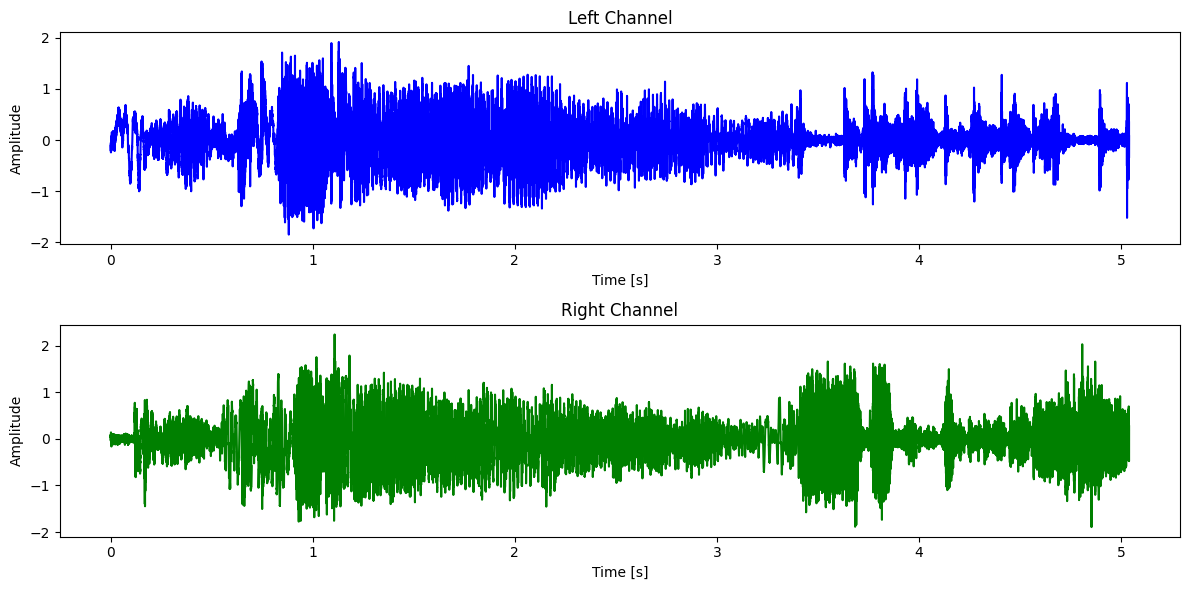

In [ ]:
plot_stereo_audio_from_array(output_values[0])

In [ ]:
from IPython.display import Audio

sampling_rate = 32000
Audio(output_values[0], rate=sampling_rate)

In [ ]:
# Get input details
inputs = ort_session.get_inputs()

# Print input names, shapes, and types
for i, input_tensor in enumerate(inputs):
    print(f"Input {i}:")
    print(f"Name: {input_tensor.name}")
    print(f"Shape: {input_tensor.shape}")
    print(f"Type: {input_tensor.type}")

In [ ]:
# import scipy

# sampling_rate = model.config.audio_encoder.sampling_rate
# scipy.io.wavfile.write("musicgen_out.wav", rate=sampling_rate, data=output_values[0].T)

### Notebook_Split

In [ ]:
raise

### Try and export the full model

Doesnt work bc of problems in attention layer

In [ ]:
class MusicGenWrapper(nn.Module):
    def __init__(self, model: MusicgenForConditionalGeneration):
        super().__init__()
        self.model = model

    def forward(self, input_ids, attention_mask, guidance_scale=3, max_new_tokens=256, temperature=2.0, top_k=500, top_p=0.0):
        '''Taken from last section of the model'''

        inputs = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

        output_values = model.generate(**inputs, guidance_scale=guidance_scale.item(), max_new_tokens=max_new_tokens.item(), temperature=temperature.item(), top_k=top_k.item(), top_p=top_p.item())

        return output_values

In [ ]:
musicgen_wrapper = MusicGenWrapper(model)

# Define the dynamic axes for variable-length input shapes
dynamic_axes = {
    'input_ids': {0: 'batch_size', 1: 'sequence_length'}, # Allow variable batch size and sequence length
    'attention_mask': {0: 'batch_size', 1: 'sequence_length'}, # Allow variable batch size and sequence length
}

# Example input shapes (with batch size = 2, sequence length = 10)
dummy_guidance_scale = torch.tensor(3, dtype=torch.int64)
dummy_max_new_tokens = torch.tensor(256, dtype=torch.int64)
dummy_temperature = torch.tensor(2.0, dtype=torch.float32)
dummy_top_k = torch.tensor(500, dtype=torch.int64)
dummy_top_p = torch.tensor(0.0, dtype=torch.float32)

# Export the model to ONNX format
torch.onnx.export(
    musicgen_wrapper,
    (inputs['input_ids'], inputs['attention_mask'], dummy_guidance_scale, dummy_max_new_tokens, dummy_temperature, dummy_top_k, dummy_top_p),
    f"{folder}/musicgen.onnx", 
    input_names=[
        'input_ids',
        'attention_mask',
        'guidance_scale',
        'max_new_tokens',
        'temperature',
        'top_k',
        'top_p'
    ],
    output_names=['output_values'],
    dynamic_axes=dynamic_axes
)

### Other Exports

#### Export the projection layer

In [ ]:
# Define the dynamic axes for variable-length input shapes
dynamic_axes = {
    'encoder_hidden_states_in': {0: 'batch_size', 1: 'sequence_length'},  # Allow variable batch size and sequence length
    'encoder_hidden_states_out': {0: 'batch_size', 1: 'sequence_length'}  # Output will also have variable batch size and sequence length
}

# Example input shapes (with batch size = 2, sequence length = 10)
dummy_encoder_hidden_states = torch.randint(0, 100, (2, 12, 768), dtype=torch.float32)

# Export the model to ONNX format
torch.onnx.export(
    model.enc_to_dec_proj,                             # Model to export
    (dummy_encoder_hidden_states,),                             # Example input tuple
    f"{folder}/enc_to_dec_proj.onnx",               # Export path
    input_names=['encoder_hidden_states_in'],          # Input tensor names
    output_names=['encoder_hidden_states_out'],         # Output tensor name
    dynamic_axes=dynamic_axes,
    opset_version=optset_version                       # Dynamic axes for variable-length inputs
)

#### Export the decoder layer

In [ ]:
class DecoderWrapper(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.decoder = decoder
        self.past_key_values = None

    def forward(self, input_ids, encoder_hidden_states, encoder_attention_mask):
        outputs = self.decoder(
            input_ids = input_ids,
            attention_mask = None,
            encoder_hidden_states = encoder_hidden_states,
            encoder_attention_mask = encoder_attention_mask,
            head_mask = None,
            cross_attn_head_mask = None,
            past_key_values = self.past_key_values,
            inputs_embeds = None,
            labels = None,
            use_cache = True,
            output_attentions = False,
            output_hidden_states = False,
            return_dict = True
        )

        self.past_key_values = outputs.past_key_values

        logits = outputs.logits

        return logits

In [ ]:
decoder_wrapper = DecoderWrapper(model.decoder)

# Define the dynamic axes for variable-length input shapes
dynamic_axes = {
    'input_ids': {0: 'batch_size'},
    'encoder_hidden_states': {0: 'batch_size', 1: 'sequence_length'},
    'encoder_attention_mask': {0: 'batch_size', 1: 'sequence_length'}
}

# Example input shapes (with batch size = 2, sequence length = 10)
dummy_input_ids = torch.randint(0, 100, (16, 1), dtype=torch.int64)
dummy_encoder_hidden_states = torch.randn((2, 18, 1024), dtype=torch.float32)
dummy_encoder_attention_mask = torch.randint(0, 100, (2, 18), dtype=torch.int64)

# Export the model to ONNX format
torch.onnx.export(
    decoder_wrapper,
    (
        dummy_input_ids,
        dummy_encoder_hidden_states,
        dummy_encoder_attention_mask,
    ),
    f"{folder}/decoder.onnx",
    input_names=[
        'input_ids',
        'encoder_hidden_states',
        'encoder_attention_mask',
    ],
    output_names=['logits'],
    dynamic_axes=dynamic_axes,
    opset_version=optset_version
)

### Ignore

In [ ]:
ort_session = ort.InferenceSession(f"{folder}/audio_token_decoder.onnx")

# Prepare input data (assuming you already have input_ids and attention_mask as PyTorch tensors)
input_ids_np = output_ids.detach().numpy()  # Convert to NumPy arrays if they're in PyTorch tensors
attention_mask_np = decoder_delay_pattern_mask.detach().numpy()  # Convert to NumPy arrays if they're in PyTorch tensors
pad_token_np = torch.tensor(2048, dtype=torch.int64).detach().numpy()  # Convert to NumPy arrays if they're in PyTorch tensors

# Run the model
ort_inputs = {
    # 'input_ids': np.expand_dims(np.concatenate((input_ids_np, attention_mask_np), axis=0), 0),
    'output_ids': input_ids_np,
    'decoder_delay_pattern_mask': attention_mask_np,
    'pad_token_id': pad_token_np
}
encoded = ort_session.run(None, ort_inputs)[0]

In [ ]:
import onnx

# Load the ONNX model
model_path = f"{folder}/sampler.onnx"  # Update this with your ONNX model path
onnx_model = onnx.load(model_path)

# Print model input names and their shapes
print("Model Inputs:")
for input_tensor in onnx_model.graph.input:
    print(f"Input name: {input_tensor.name}")


In [ ]:
with open("forward_method_code.py", "w") as file:
    file.write(inspect.getsource(model.text_encoder.encoder.forward))

In [ ]:
with open("forward_method_code.py", "w") as file:
    file.write(inspect.getsource(model.audio_encoder.quantizer.decode))

In [ ]:
with open("forward_method_code.py", "w") as file:
    file.write(inspect.getsource(model.audio_encoder._decode_frame))

In [ ]:
with open("forward_method_code.py", "w") as file:
    file.write(inspect.getsource(model.audio_encoder.decode))

In [ ]:
model.audio_encoder.config

In [ ]:
# Define the dynamic axes for variable-length input shapes
dynamic_axes = {
    'encoder_hidden_states_in': {0: 'batch_size', 1: 'sequence_length'},  # Allow variable batch size and sequence length
    'encoder_hidden_states_out': {0: 'batch_size', 1: 'sequence_length'}  # Output will also have variable batch size and sequence length
}

# Example input shapes (with batch size = 2, sequence length = 10)
dummy_encoder_hidden_states = torch.randint(0, 100, (2, 12, 768), dtype=torch.float32)

# Export the model to ONNX format
torch.onnx.export(
    model.enc_to_dec_proj,                             # Model to export
    (dummy_encoder_hidden_states,),                             # Example input tuple
    f"{folder}/enc_to_dec_proj.onnx",               # Export path
    input_names=['encoder_hidden_states_in'],          # Input tensor names
    output_names=['encoder_hidden_states_out'],         # Output tensor name
    dynamic_axes=dynamic_axes                       # Dynamic axes for variable-length inputs
)

Export the audio_encoder

In [ ]:
ort_session = ort.InferenceSession(f"{folder}/text_encoder.onnx")

# Prepare input data (assuming you already have input_ids and attention_mask as PyTorch tensors)
input_ids_np = inputs['input_ids'].detach().numpy()  # Convert to NumPy arrays if they're in PyTorch tensors
attention_mask_np = inputs['attention_mask'].detach().numpy()  # Convert to NumPy arrays if they're in PyTorch tensors

# Run the model
ort_inputs = {
    'input_ids': input_ids_np,
    'attention_mask': attention_mask_np,
    'cfg': np.array([3], dtype=np.int64)
}
encoded = ort_session.run(None, ort_inputs)[0]
encoded